In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping

In [2]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()


In [3]:
import pandas as pd

df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = data.target
df.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
X, y = data.data, data.target

In [5]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

In [7]:
lrs = [0.2, 0.03, 0.05]
lr_dict = {i:lr for i, lr in enumerate(lrs)}

In [ ]:
# 3. définir un couple learning_rate / n_estimators cohérent
evals_result = {}
train_logloss = {}
val_logloss = {}
best_iteration = {}
for index, lr in lr_dict.items():
    model = XGBClassifier(
        n_estimators=1000,      # grande valeur
        learning_rate=lr,     # plus petit que le défaut pour des pas plus fins
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective="binary:logistic",
        eval_metric="logloss" ,
        early_stopping_rounds=20,
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=True
    )

    preds = model.predict(X_test)
    print("Accuracy test:", accuracy_score(y_test, preds))
    print("Meilleur nombre d'arbres:", model.best_iteration + 1)

    best_iteration[index] = model.best_iteration + 1
    evals_result[index] = model.evals_result()
    train_logloss[index] = evals_result[index]["validation_0"]["logloss"]
    val_logloss[index] = evals_result[index]["validation_1"]["logloss"]

[0]	validation_0-logloss:0.50961	validation_1-logloss:0.51150
[1]	validation_0-logloss:0.40829	validation_1-logloss:0.42025
[2]	validation_0-logloss:0.33055	validation_1-logloss:0.34401
[3]	validation_0-logloss:0.27535	validation_1-logloss:0.29832
[4]	validation_0-logloss:0.23032	validation_1-logloss:0.25687
[5]	validation_0-logloss:0.19349	validation_1-logloss:0.22421
[6]	validation_0-logloss:0.16502	validation_1-logloss:0.20348
[7]	validation_0-logloss:0.14311	validation_1-logloss:0.18739
[8]	validation_0-logloss:0.12379	validation_1-logloss:0.17098
[9]	validation_0-logloss:0.10715	validation_1-logloss:0.15804
[10]	validation_0-logloss:0.09399	validation_1-logloss:0.14842
[11]	validation_0-logloss:0.08313	validation_1-logloss:0.14121
[12]	validation_0-logloss:0.07370	validation_1-logloss:0.13458
[13]	validation_0-logloss:0.06646	validation_1-logloss:0.13366
[14]	validation_0-logloss:0.06019	validation_1-logloss:0.13014
[15]	validation_0-logloss:0.05508	validation_1-logloss:0.12850
[1

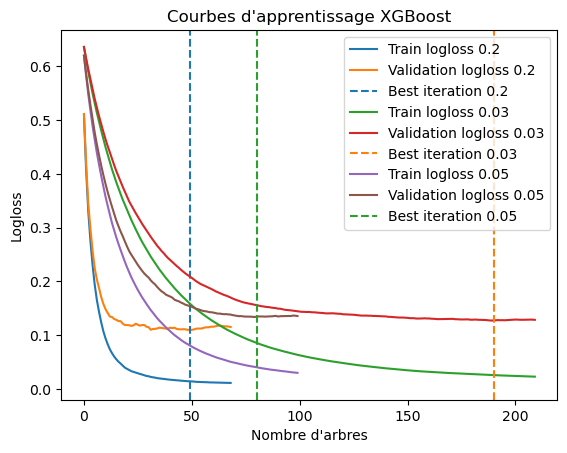

In [70]:
import matplotlib.pyplot as plt
colors = plt.cm.tab10.colors  # palette de 10 couleurs distinctesplt.figure(figsize=(8, 4))
for results in range(len(evals_result)):
    plt.plot(train_logloss[results], label=f"Train logloss {lr_dict[results]}")
    plt.plot(val_logloss[results], label=f"Validation logloss {lr_dict[results]}")
    plt.axvline(best_iteration[results], color=colors[results % len(colors)], linestyle="--", label=f"Best iteration {lr_dict[results]}")

plt.xlabel("Nombre d'arbres")
plt.ylabel("Logloss")
plt.title("Courbes d'apprentissage XGBoost")
plt.legend()
plt.show()